In [1]:
!pip install numpy pandas scikit-learn nltk

In [2]:
!pip install nltk

In [3]:
!pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.2 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet', force=True)
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

**Loading data**

In [5]:
def load_data(folder):
    data = []
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
                data.append(file.read())
    return data

In [6]:
neg_path = "/kaggle/input/reviews/txt_sentoken/neg"
pos_path = "/kaggle/input/reviews/txt_sentoken/pos"

neg_reviews = load_data(neg_path)
pos_reviews = load_data(pos_path)

df = pd.DataFrame({
    'review': neg_reviews + pos_reviews,
    'sentiment': ['neg'] * len(neg_reviews) + ['pos'] * len(pos_reviews)
})

In [7]:
df.head()

,review,sentiment
0,words i thought i'd never write : the sequel t...,neg
1,""" tina ! ! ! fetch me the axe ! ! ! "" \na fav...",neg
2,"hav plenty , as we are told in the beginning a...",neg
3,the first scene of operation condor has jackie...,neg
4,the title is taken from the writings of ralph ...,neg


In [8]:
df.describe()

,review,sentiment
count,2000,2000
unique,2000,2
top,synopsis : shrek ( myers ) is an ogre living i...,neg
freq,1,1000


In [9]:
df.isna().sum() # Checking for any missing values

review       0
sentiment    0
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

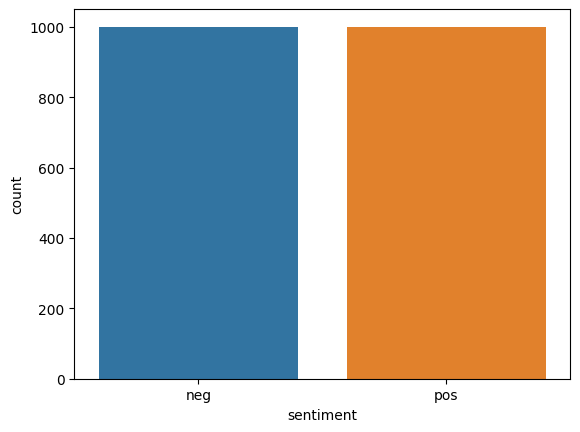

In [10]:
import seaborn as sns
# Plot countplot using the encoded DataFrame
sns.countplot(data=df, x='sentiment')

**Generate wordcloud**

In [11]:
# Function to generate word cloud from reviews
def generate_wordcloud(reviews, title):
    # Concatenate all reviews into a single string
    text = ' '.join(reviews)
    stop_words = list(WordCloud().stopwords)
    custom_words = ['movie', 'film']
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color ='white', stopwords=set(stop_words + custom_words)).generate(text)
    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Separate positive and negative reviews
positive_reviews = df[df['sentiment'] == 'pos']['review'].tolist()
negative_reviews = df[df['sentiment'] == 'neg']['review'].tolist()

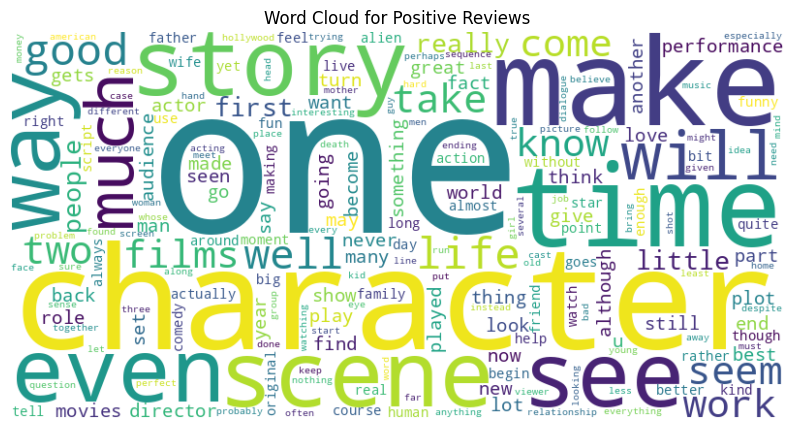

In [12]:
# Generate word cloud for positive reviews
generate_wordcloud(positive_reviews, 'Word Cloud for Positive Reviews')

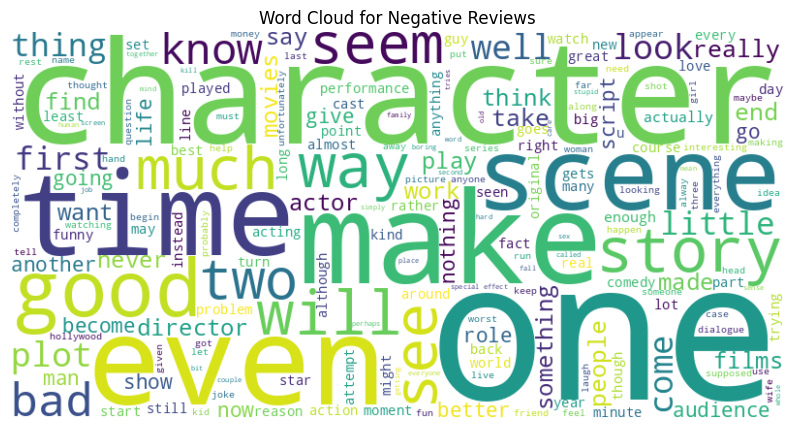

In [13]:
# Generate word cloud for negative reviews
generate_wordcloud(negative_reviews, 'Word Cloud for Negative Reviews')

**Label encoding**

In [14]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'sentiment' column
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

df.head(5)

,review,sentiment
0,words i thought i'd never write : the sequel t...,0
1,""" tina ! ! ! fetch me the axe ! ! ! "" \na fav...",0
2,"hav plenty , as we are told in the beginning a...",0
3,the first scene of operation condor has jackie...,0
4,the title is taken from the writings of ralph ...,0


**Number of words in each text**

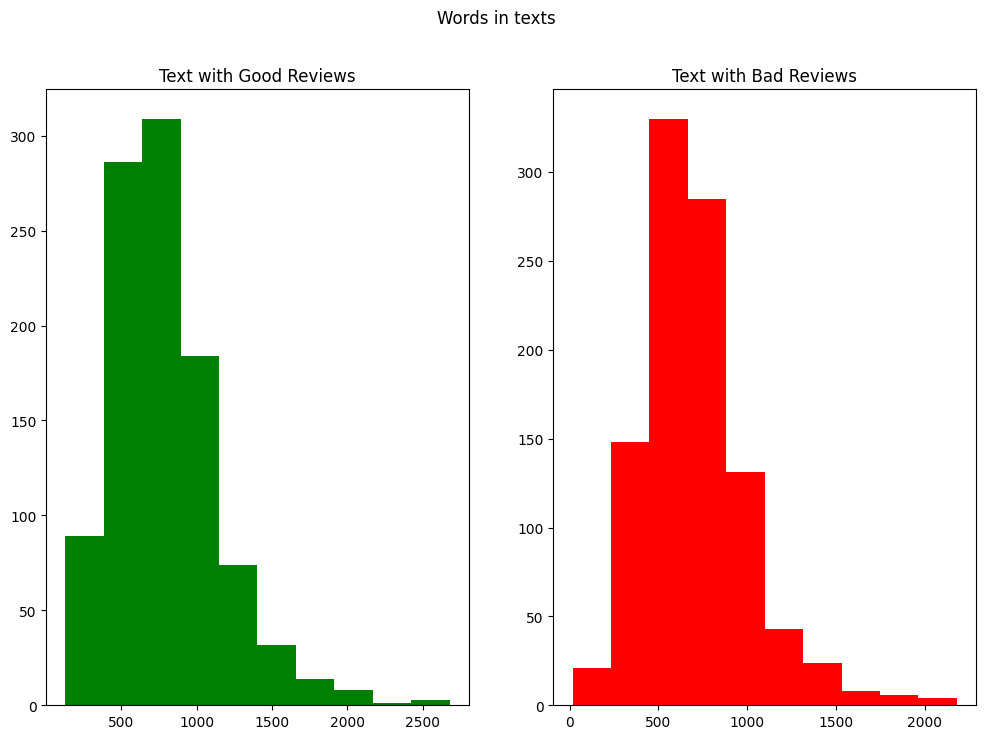

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Words in texts')
plt.show()

**preprocessing**

In [16]:
def cleanText(x):
    x = [text.lower() for text in x]
    cleaned = []
    for txt in x:
        txt = txt.replace("wasn't", 'was not')
        txt = txt.replace("weren't", 'were not')
        txt = txt.replace("aren't", 'are not')
        txt = txt.replace("isn't", 'is not')
        txt = txt.replace("don't", 'do not')
        txt = txt.replace("doesn't", 'does not')
        txt = txt.replace("didn't", 'did not')
        txt = txt.replace("shouldn't", 'should not')
        txt = txt.replace("i'm", 'i am')
        txt = txt.replace("isn't", 'is not')
        word_tokens = word_tokenize(txt)
        sentence = ' '.join(contractions.fix(word) for word in word_tokens)
        cleaned.append(sentence)
    return cleaned

In [17]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import contractions

# Initialize stemmer and define stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define preprocess_text function
def preprocess_text(text):
    cleaned_texts = cleanText([text])
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in string.punctuation]

    # Removing stopwords and single characters
    filtered_tokens = [word for word in filtered_tokens if word not in stop_words and len(word) > 1]

    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return ' '.join(stemmed_tokens)

In [18]:
df['review'] = df['review'].apply(preprocess_text)

In [19]:
df['review']

0       word thought never write sequel urban legend l...
1       tina fetch axe favourit book mine call golden ...
2       hav plenti told begin remind film true stori l...
3       first scene oper condor jacki chan prepar secr...
4       titl taken write ralph waldo emerson describ l...
                              ...                        
1995    garri shandl make long overdu star film debut ...
1996    seem two reaction dark citi either love unimpr...
1997    question ask ventur nervous wed singer latest ...
1998    synopsi respons accus sexual prejudic arm forc...
1999    synopsi shrek myer ogr live content solitud de...
Name: review, Length: 2000, dtype: object

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


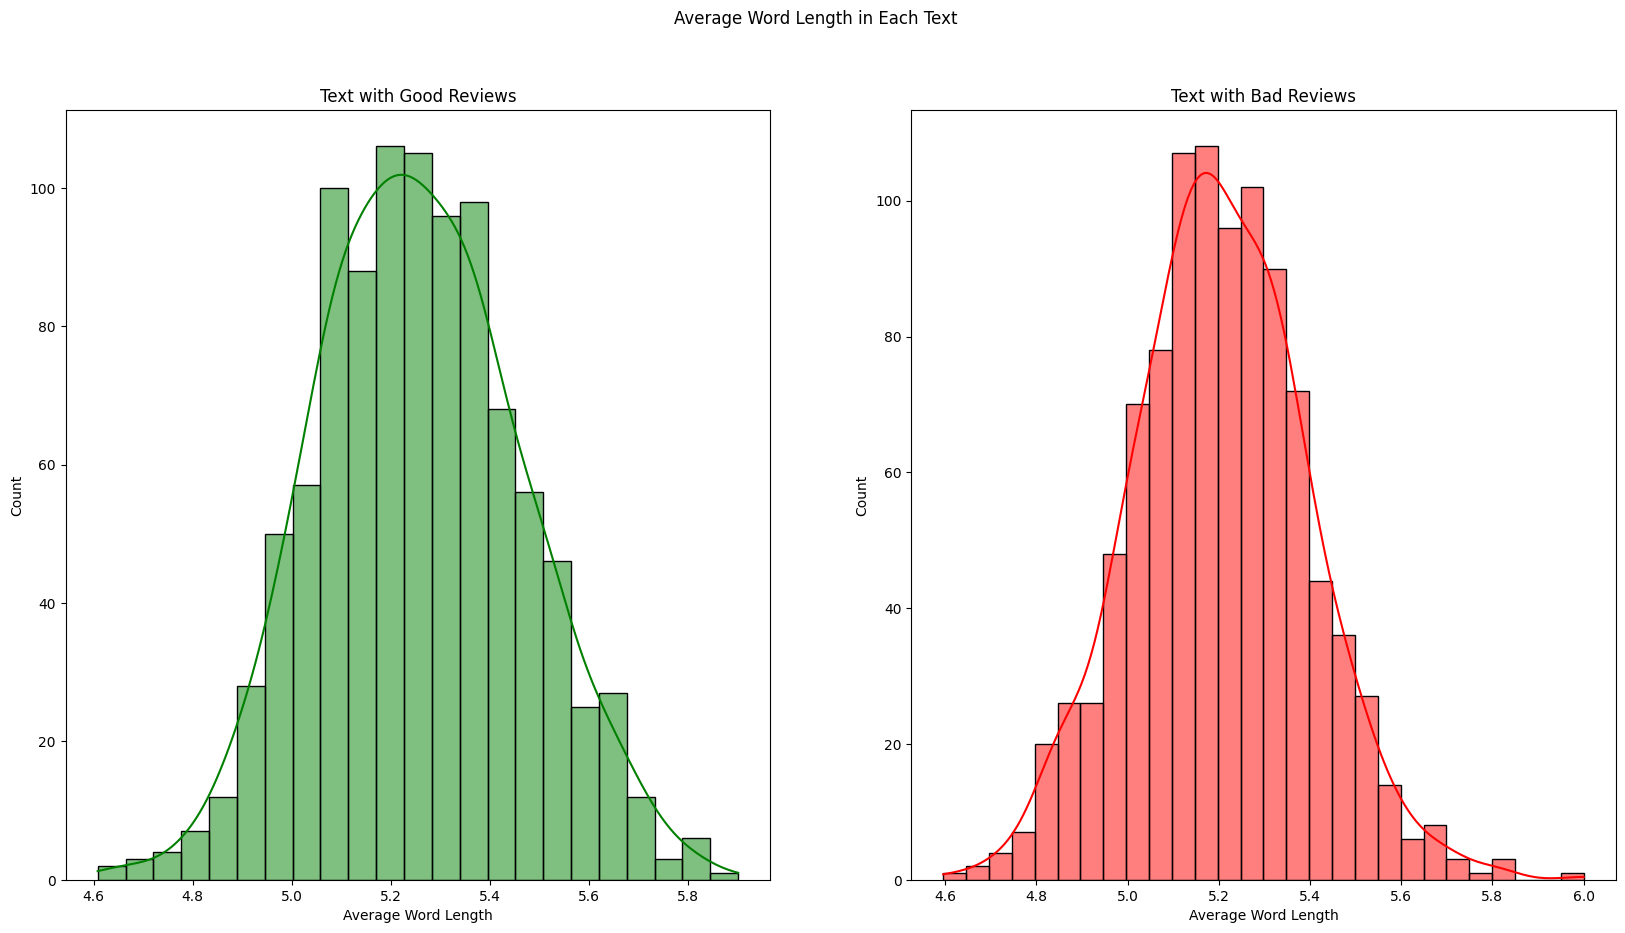

In [20]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# Calculate word lengths for positive reviews
word_pos = df[df['sentiment'] == 1]['review'].str.split().apply(lambda x: [len(i) for i in x])
word_pos_mean = word_pos.map(lambda x: np.mean(x))
sns.histplot(word_pos_mean, ax=ax1, color='green', kde=True)
ax1.set_title('Text with Good Reviews')
ax1.set_xlabel('Average Word Length')

# Calculate word lengths for negative reviews
word_neg = df[df['sentiment'] == 0]['review'].str.split().apply(lambda x: [len(i) for i in x])
word_neg_mean = word_neg.map(lambda x: np.mean(x))
sns.histplot(word_neg_mean, ax=ax2, color='red', kde=True)
ax2.set_title('Text with Bad Reviews')
ax2.set_xlabel('Average Word Length')

# Set common title
plt.suptitle('Average Word Length in Each Text')

# Show plot
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

**Vectorization**


We have to convert variable length strings of text to fixed length numerical vectors to able to train machine learning models on this data. There are two popular approaches for this.

**TF-IDF**: multiples term frequency with inverse document frequency. This puts more weight on words that don't appear in many documents.


In [22]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

**Models**

In [23]:
def evaluate_model(y_true, y_pred):
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)

    # Generate a classification report
    report = classification_report(y_true, y_pred)    
    print("Classification Report:\n", report)
    return accuracy

In [24]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

#  SVC

In [25]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']}

grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_train_vectors, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']})

In [26]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1, gamma=1, kernel='linear')


In [27]:
grid_predictions = grid.best_estimator_.predict(X_test_vectors)
Svc_accuracy=evaluate_model(y_test, grid_predictions)

Accuracy: 0.8725
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       199
           1       0.88      0.87      0.87       201

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



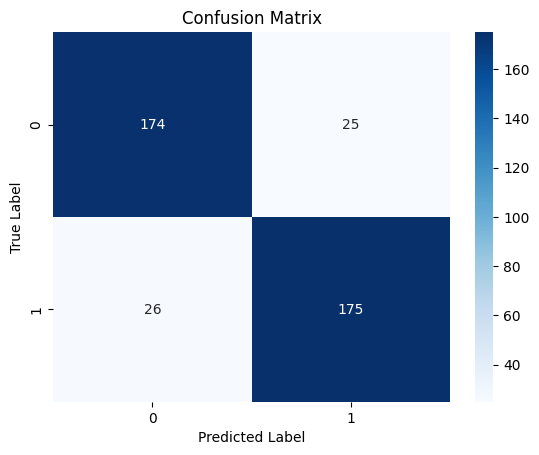

In [28]:
plot_confusion_matrix(y_test, grid_predictions)

In [29]:
joblib.dump(grid.best_estimator_, 'svm.pkl')

['svm.pkl']

# LogisticRegression

In [30]:
model = LogisticRegression(max_iter=1000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search.fit(X_train_vectors, y_train)

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
logistic_regression = grid_search.best_estimator_
y_pred = logistic_regression.predict(X_test_vectors)
lr_accuracy=evaluate_model(y_test, y_pred)

Best: 0.835208 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       199
           1       0.86      0.86      0.86       201

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



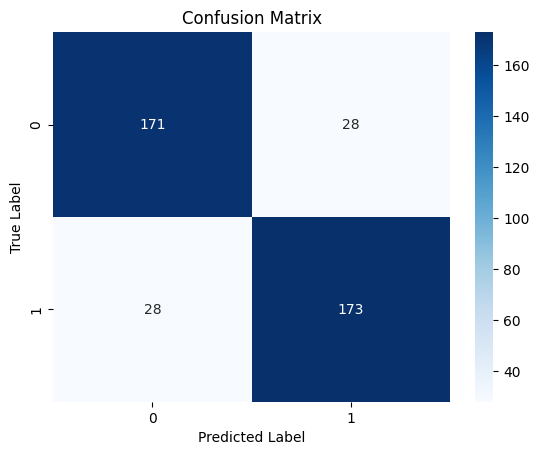

In [31]:
plot_confusion_matrix(y_test, y_pred)

In [32]:
joblib.dump(logistic_regression, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

# RandomForestClassifier

In [33]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_vectors, y_train)
y_pred = random_forest.predict(X_test_vectors)
rf_accuracy=evaluate_model(y_test, y_pred)

Accuracy: 0.8125
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83       199
           1       0.89      0.71      0.79       201

    accuracy                           0.81       400
   macro avg       0.83      0.81      0.81       400
weighted avg       0.83      0.81      0.81       400



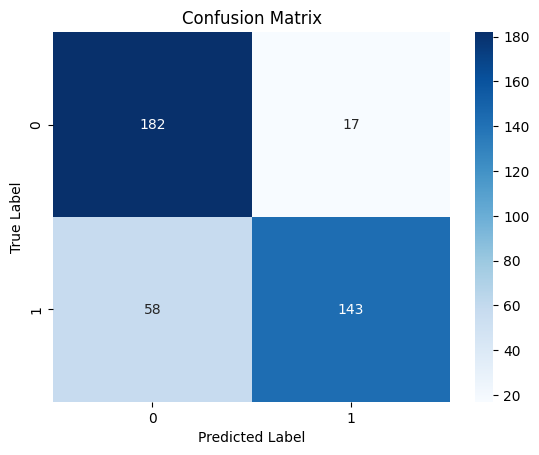

In [34]:
plot_confusion_matrix(y_test, y_pred)

In [35]:
joblib.dump(random_forest, 'random_forest.pkl')

['random_forest.pkl']

# **Decision Tree Classifier**

In [36]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_vectors, y_train)
y_pred = dt_classifier.predict(X_test_vectors)
dt_accuracy=evaluate_model(y_test, y_pred)

Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.63      0.64       199
           1       0.64      0.65      0.64       201

    accuracy                           0.64       400
   macro avg       0.64      0.64      0.64       400
weighted avg       0.64      0.64      0.64       400



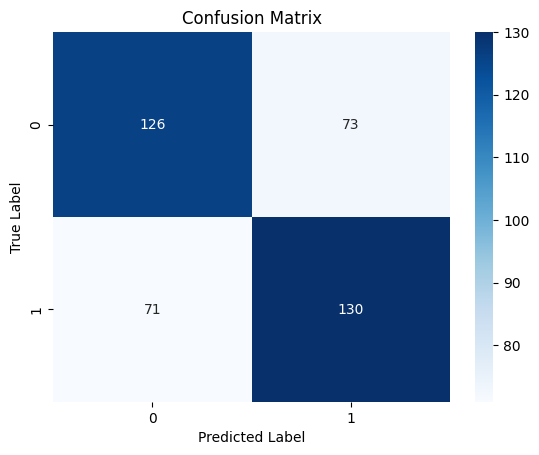

In [37]:
plot_confusion_matrix(y_test, y_pred)

In [38]:
joblib.dump(dt_classifier, 'decision_tree.pkl')

['decision_tree.pkl']

**load best model**

In [39]:
loaded_model = joblib.load('/kaggle/working/svm.pkl')

In [40]:
new_text = [preprocess_text("This movie was great!")]
new_text_vector = vectorizer.transform(new_text)
predicted_label = loaded_model.predict(new_text_vector)
if predicted_label == 1:
    print("Predicted Label: Positive")
else:
    print("Predicted Label: Negative")

Predicted Label: Positive


**Model Accuracy Comparison**

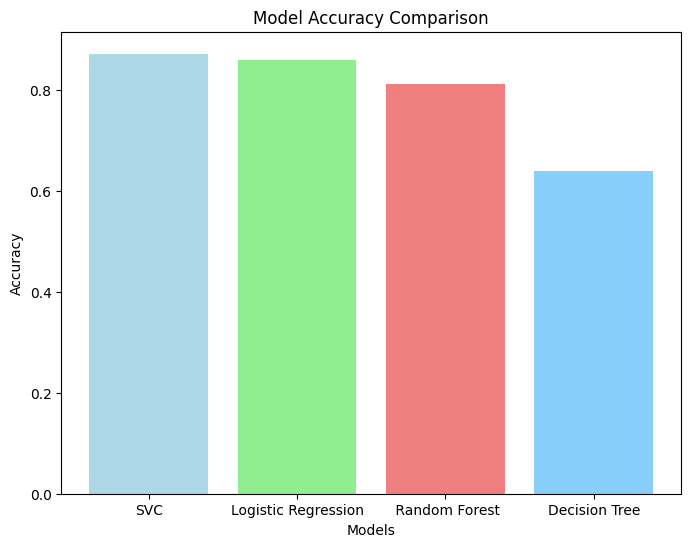

In [41]:
models = ['SVC', 'Logistic Regression', ' Random Forest', 'Decision Tree']
accuracy = [Svc_accuracy, lr_accuracy, rf_accuracy, dt_accuracy]  
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue']

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracy, color=colors)

plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')

plt.show()